# 빅데이터분석(21_2)
### 휴먼지능정보공학과 201810793 이연우
* 13주차 과제
---

# iris데이터 회귀분석

독립변수는 petal_length 컬럼, 종속변수는 petal_width 컬럼으로 해보자.

In [1]:
# SparkSession 생성
import pyspark
import os

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

### 1) DataFrame 생성

In [2]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [3]:
irisDf=spark.createDataFrame(iris)
irisDf.printSchema()
irisDf.show()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
|         4.9

### 2) 회귀선 그래프

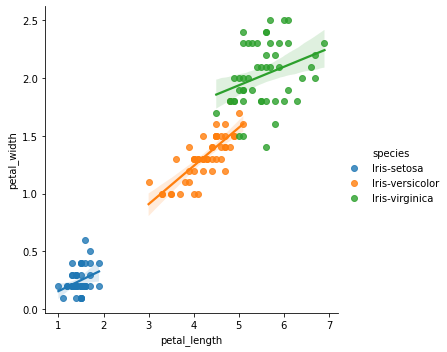

In [4]:
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris, hue='species')

### 3) Spark를 사용하여 회귀분석하고 계수 출력

In [5]:
(trainDf, testDf) = irisDf.randomSplit([0.9, 0.1])

In [6]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="species", outputCol="speciesIndex")

In [7]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="speciesIndex", outputCol="speciesVec")

In [8]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["speciesVec", "petal_width"],
                                   outputCol = 'features')

In [9]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_length', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [10]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [11]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [12]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.0,-1.0561587297754687,1.2661141606274997]
Intercept: 2.581


### 4) 실제와 예측 출력

In [13]:
modelTestDf=model.transform(testDf)

In [14]:
modelTestDf.select('petal_length','prediction').show(10)

+------------+-----------------+
|petal_length|       prediction|
+------------+-----------------+
|         1.3| 1.77794061308964|
|         1.3| 1.77794061308964|
|         1.4| 1.90455202915239|
|         1.2| 1.77794061308964|
|         4.4|4.100213503492609|
|         4.9|5.113104831994608|
|         5.0|4.480047751680859|
|         4.5|4.480047751680859|
|         4.5|4.480047751680859|
|         5.6|5.239716248057358|
+------------+-----------------+
only showing top 10 rows



### 5) 정확성 평가 출력

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="rmse")

In [16]:
rmse=evaluator.evaluate(modelTestDf)

In [17]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.623'

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="r2")

In [19]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.895'